Датасет https://www.kaggle.com/gti-upm/leapgestrecog


In [1]:
import os
import random
import math
# from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
# import xml.etree.ElementTree as ET

import torch
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
# import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import time
import seaborn

import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN

In [2]:
images_dir = Path('data/leapGestRecog/00')

In [3]:
label_dict = {}
classes_train = []
classes_test = []
for folder in os.listdir(images_dir):
    label = int(folder[0:2])-1
    class_name = folder[3:]
    label_dict[label] = class_name
    classes_train.append(class_name)
    classes_test.append(class_name)

In [4]:
label_dict

{0: 'palm',
 1: 'l',
 2: 'fist',
 3: 'fist_moved',
 4: 'thumb',
 5: 'index',
 6: 'ok',
 7: 'palm_moved',
 8: 'c',
 9: 'down'}

In [5]:
transforms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.CenterCrop(280), tt.Resize(64), tt.ToTensor()])
for folder in os.listdir('data/leapGestRecog'):
    images = ImageFolder(os.path.join('data/leapGestRecog', folder), transforms)

In [6]:
images

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: data/leapGestRecog\09
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               CenterCrop(size=(280, 280))
               Resize(size=64, interpolation=bilinear)
               ToTensor()
           )

In [7]:
X_train, X_test = train_test_split(images, test_size = 0.3, random_state = 42)

In [8]:
train_dataloader = DataLoader(X_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(X_test, batch_size=16)

torch.Size([1, 64, 64])


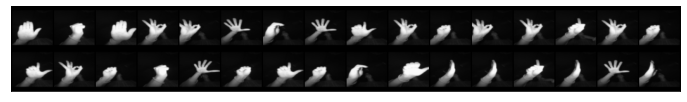

In [9]:
def showbatch(batch):
    for images, labels in batch:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=16).permute(1, 2, 0))
        break

showbatch(train_dataloader)

In [10]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

Узнаем какое оборудование у нас:

In [11]:
device = get_default_device()
device

device(type='cuda')

Воспользуемся функциями написанными выше:

In [12]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

In [13]:
# class ResNet(nn.Module):
#     def __init__(self, in_channels, num_classes):
#         super().__init__()
        
#         self.conv1 = self.conv_block(in_channels, 128)
#         self.conv2 = self.conv_block(128, 128, pool=True)
#         self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
#         self.drop1 = nn.Dropout(0.5)
        
#         self.conv3 = self.conv_block(128, 256)
#         self.conv4 = self.conv_block(256, 256, pool=True)
#         self.res2 = nn.Sequential(self.conv_block(256, 256), self.conv_block(256, 256))
#         self.drop2 = nn.Dropout(0.5)
        
#         self.conv5 = self.conv_block(256, 512)
#         self.conv6 = self.conv_block(512, 512, pool=True)
#         self.res3 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))
#         self.drop3 = nn.Dropout(0.5)
        
#         self.classifier = nn.Sequential(nn.MaxPool2d(6), 
#                                         nn.Flatten(),
#                                         nn.Linear(512, num_classes),
#                                         nn.Softmax(dim=1))
        
#     @staticmethod
#     def conv_block(in_channels, out_channels, pool=False):
#         layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
#                   nn.BatchNorm2d(out_channels), 
#                   nn.ELU(inplace=True)]
#         if pool: layers.append(nn.MaxPool2d(2))
#         return nn.Sequential(*layers)
        
#     def forward(self, xb):
#         out = self.conv1(xb)
#         out = self.conv2(out)
#         out = self.res1(out) + out
#         out = self.drop1(out)
        
#         out = self.conv3(out)
#         out = self.conv4(out)
#         out = self.res2(out) + out
#         out = self.drop2(out)
        
#         out = self.conv5(out)
#         out = self.conv6(out)
#         out = self.res3(out) + out
#         out = self.drop3(out)
        
#         out = self.classifier(out)
#         return out
        

In [14]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 32)
        self.conv2 = self.conv_block(32, 32, pool=True)
        self.res1 = nn.Sequential(self.conv_block(32, 32), self.conv_block(32, 32))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = self.conv_block(32, 64)
        self.conv4 = self.conv_block(64, 64, pool=True)
        self.res2 = nn.Sequential(self.conv_block(64, 64), self.conv_block(64, 64))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = self.conv_block(64, 128)
        self.conv6 = self.conv_block(128, 128, pool=True)
        self.res3 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(128, num_classes),
                                        nn.Softmax(dim=1))
        
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out
        

In [15]:
model = to_device(ResNet(1, len(classes_train)), device)

In [16]:
# Если работаете на гпу, очищаем весь кэш
if torch.cuda.is_available(): 
    torch.cuda.empty_cache()


epochs = 30
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr)

In [17]:
total_steps = len(train_dataloader)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

30 epochs, 44 total_steps per epoch


Добавим learning_rate_sheduler:

In [18]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dataloader))

In [19]:
epoch_losses = []
true_y = []
pred_y = []

sm=nn.Softmax(dim=0)

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dataloader):
        data, labels = data.cuda(), labels.cuda()       
        
        optimizer.zero_grad()
        
        outputs = model(data)
        
        _, preds = torch.max(outputs, 1)
        
        true_y.append(labels.to('cpu'))
        pred_y.append(outputs.to('cpu'))
        
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)
    

Epoch 1, loss:  2.3419468944722954
Epoch 2, loss:  2.3097699121995405
Epoch 3, loss:  2.25731054761193
Epoch 4, loss:  2.171128354289315
Epoch 5, loss:  2.0613873546773736
Epoch 6, loss:  1.967278309843757
Epoch 7, loss:  1.8859717520800503
Epoch 8, loss:  1.8720514178276062
Epoch 9, loss:  1.8633346909826451
Epoch 10, loss:  1.8572754426435991
Epoch 11, loss:  1.8570344420996578
Epoch 12, loss:  1.8370595628565007
Epoch 13, loss:  1.7666494087739424
Epoch 14, loss:  1.760615199804306
Epoch 15, loss:  1.7580334869298069
Epoch 16, loss:  1.754408977248452
Epoch 17, loss:  1.6725793887268414
Epoch 18, loss:  1.6572864055633545
Epoch 19, loss:  1.6565332087603482
Epoch 20, loss:  1.6550213748758489
Epoch 21, loss:  1.6549091718413613
Epoch 22, loss:  1.6552465151656757
Epoch 23, loss:  1.6538083363663068
Epoch 24, loss:  1.6539457006887957
Epoch 25, loss:  1.6532283073121852
Epoch 26, loss:  1.6535504920916124
Epoch 27, loss:  1.6531058658253064
Epoch 28, loss:  1.6538745652545581
Epoch 2

Посмотрим на нашу ошибку в процессе обучения:

Text(0.5, 1.0, 'losses vs. No. of epochs')

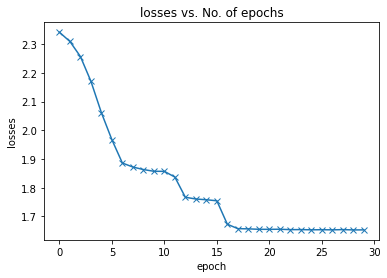

In [20]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

In [21]:
torch.save(model.state_dict(), 'models/gesture_detection_model_state_30_epochs.pth')

In [22]:
net=ResNet(1, len(classes_train)).to(device)
net.load_state_dict(torch.load('models/gesture_detection_model_state_30_epochs.pth'))
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

torch.Size([16, 1, 64, 64])
torch.Size([10])
down


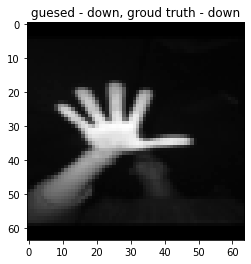

torch.Size([16, 1, 64, 64])
torch.Size([10])
fist_moved


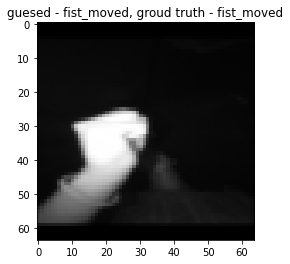

torch.Size([16, 1, 64, 64])
torch.Size([10])
fist


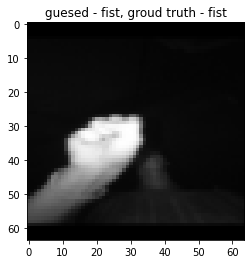

torch.Size([16, 1, 64, 64])
torch.Size([10])
palm


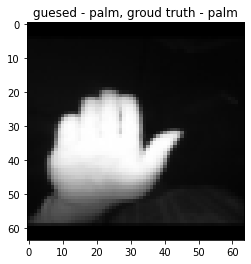

torch.Size([16, 1, 64, 64])
torch.Size([10])
down


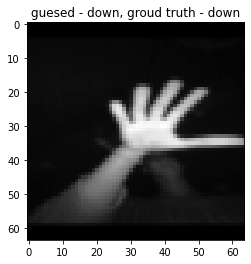

torch.Size([16, 1, 64, 64])
torch.Size([10])
palm


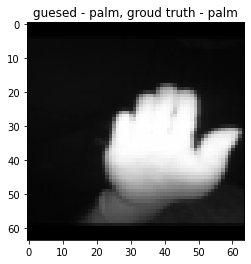

torch.Size([16, 1, 64, 64])
torch.Size([10])
fist_moved


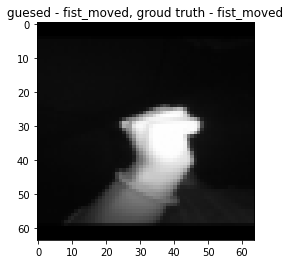

torch.Size([16, 1, 64, 64])
torch.Size([10])
index


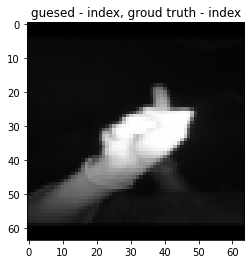

torch.Size([16, 1, 64, 64])
torch.Size([10])
index


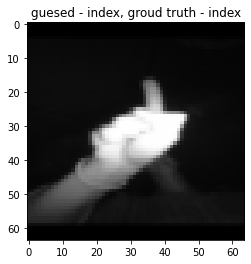

torch.Size([16, 1, 64, 64])
torch.Size([10])
palm_moved


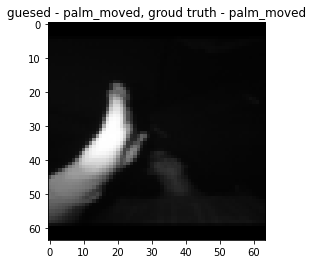

torch.Size([16, 1, 64, 64])
torch.Size([10])
fist_moved


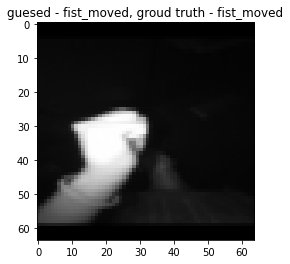

torch.Size([16, 1, 64, 64])
torch.Size([10])
fist_moved


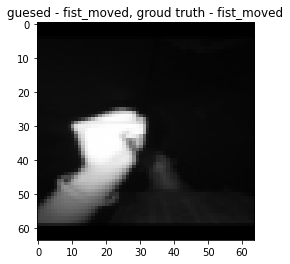

In [23]:
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        images, labels = data
        images, labels = images, labels
        outputs = net(images)
        print(images.shape)
        print(outputs[0].shape)
        print(label_dict[outputs[0].argmax().item()])
        
        plt.title(f'guesed - {label_dict[outputs[0].argmax().item()]}, groud truth - {label_dict[labels[0].data.item()]}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break

''

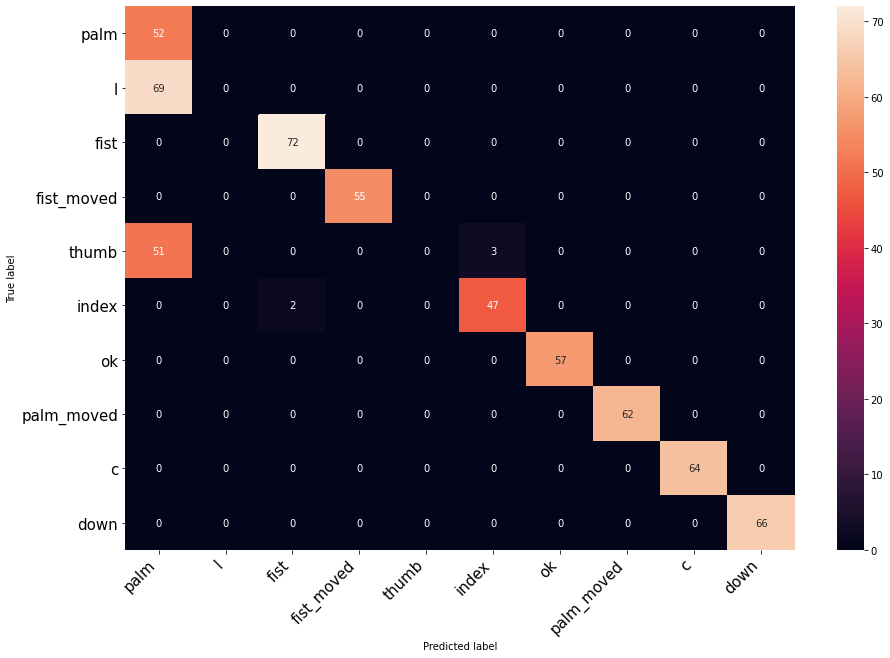

In [24]:
confusion_matrix = torch.zeros(10, 10)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

class_names = list(label_dict.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = seaborn.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
;

### Прототип приложения для определения жестов человека перед веб-камерой

In [33]:
class FaceDetector(object):

    def __init__(self, mtcnn, emodel, channels=1):
        # Создаем объект для считывания потока с веб-камеры(обычно вебкамера идет под номером 0. иногда 1)
        self.cap = cv2.VideoCapture(0) 
        self.mtcnn = mtcnn
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.emodel = net
        self.channels = channels

    # Функция рисования найденных параметров на кадре
    def _draw(self, frame, boxes, gesture):
        try:
            for box in boxes:
                # Рисуем обрамляющий прямоугольник лица на кадре
                cv2.rectangle(frame,
                              (int(box[0]), int(box[1])),
                              (int(box[2]), int(box[3])),
                              (0, 0, 255),
                              thickness=1)

                # пишем на кадре какой жест распознан
                cv2.putText(frame, 
                    gesture, (int(box[2]), int(box[3])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                
        except Exception as e:
            print('Something wrong im draw function!')
            print(f'error : {e}')

        return frame
        
    @staticmethod
    def digit_to_classname(digit):
        if digit == 0:
            return 'palm'
        elif digit == 1:
            return 'l'
        elif digit == 2:
            return 'fist'
        elif digit == 3:
            return 'fist_moved'
        elif digit == 4:
            return 'thumb'
        elif digit == 5:
            return 'index'
        elif digit == 6:
            return 'ok'
        elif digit == 7:
            return 'palm_moved'
        elif digit == 8:
            return 'c'
        elif digit == 9:
            return 'down'
    
    # Функция для вырезания лиц с кадра
    @staticmethod
    def crop_hands(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]):int(box[3]), 
                int(box[0]):int(box[2])])
        return faces
    
     # Функция в которой будет происходить процесс считывания и обработки каждого кадра
    def run(self):              
        # Заходим в бесконечный цикл
        while True:
            # Считываем каждый новый кадр - frame
            # ret - логическая переменая. Смысл - считали ли мы кадр с потока или нет
            ret, frame = self.cap.read()
            try:
                # детектируем расположение лица на кадре, вероятности на сколько это лицо
                # и особенные точки лица
                boxes, probs, landmarks = mtcnn.detect(frame, landmarks=True)
     
                if ret:
                    print('Face detected!')
                    # Вырезаем руку из кадра (правая рука - верхний левый угол изображения)
                    hand_crop = self.crop_hands(frame, [[0, 0, 250, 250]])[0]
                    # Меняем размер изображения для входа в нейронную сеть
                    hand_img = cv2.resize(hand_crop,(64,64))
#                     hand_img = cv2.cvtColor(hand_img, cv2.COLOR_BGR2RGB)
                    # Превращаем в 1-канальное серое изображение
                    hand_img = cv2.cvtColor(hand_img, cv2.COLOR_BGR2GRAY)

                    # Далее мы подготавливаем наш кадр для считывания нс
                    # Для этого перегоним его в формат pil_image
                    hand = Image.fromarray(hand_img)
                    hand = hand.resize((64,64))
                    hand = np.asarray(hand).astype('float')
                    hand = torch.as_tensor(hand)

                    # Превращаем numpy-картинку вырезанной руки в pytorch-тензор
                    torch_hand = hand.unsqueeze(0).to(self.device).float()
                    # Загужаем наш тензор руки в нейронную сеть и получаем предсказание
                    hand = self.emodel(torch_hand[None, ...])
                    # Интерпретируем предсказание как строку нашей эмоции
                    gesture = self.digit_to_classname(hand[0].argmax().item())
                    print(gesture)

                    # Рисуем на кадре
#                     self._draw(frame, boxes, gesture)

                    cv2.imshow(gesture, hand_crop)
                    plt.imshow(torch.tensor(torch_hand.detach().cpu().numpy()[0,:,:]))  
                    
                else:
                    print('No face!')

            except Exception as e:
                print('Something wrong im main cycle!')
                print(f'error : {e}')

            # Показываем кадр в окне, и назвываем его(окно) - 'Hand Detection'
#             cv2.imshow('Hand Detection', frame)
            
            
            # Функция, которая проверяет нажатие на клавишу 'q'
            # Если нажатие произошло - выход из цикла. Конец работы приложения
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        # Очищаем все объекты opencv, что мы создали
        self.cap.release()
        cv2.destroyAllWindows()
    

Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!
c
Face detected!

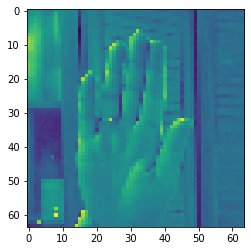

In [34]:
mtcnn = MTCNN()
fcd = FaceDetector(mtcnn, net)
# Запускаем
fcd.run()